In [2]:
import os
import sys
import folium
import pickle
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import mlflow
import matplotlib.pyplot as plt
import ipywidgets as widgets
import haversine as hs
from haversine import Unit
from IPython.display import display
from math import sin, cos, sqrt, atan2
from matplotlib.pyplot import figure
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor

mlflow.set_tracking_uri("sqlite:///delivery_time_prediction.db")
mlflow.set_experiment("delivery_time_prediction")
style = {'description_width': 'initial'}
pd.options.display.max_columns=100

2023/05/08 15:34:21 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/05/08 15:34:21 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

In [2]:
df = pd.read_csv("../data/raw/finalTrain.csv")

In [3]:
df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken (min)
0,0xcdcd,DEHRES17DEL01,36.0,4.2,30.327968,78.046106,30.397968,78.116106,12-02-2022,21:55,22:10,Fog,Jam,2,Snack,motorcycle,3.0,No,Metropolitian,46
1,0xd987,KOCRES16DEL01,21.0,4.7,10.003064,76.307589,10.043064,76.347589,13-02-2022,14:55,15:05,Stormy,High,1,Meal,motorcycle,1.0,No,Metropolitian,23
2,0x2784,PUNERES13DEL03,23.0,4.7,18.562450,73.916619,18.652450,74.006619,04-03-2022,17:30,17:40,Sandstorms,Medium,1,Drinks,scooter,1.0,No,Metropolitian,21
3,0xc8b6,LUDHRES15DEL02,34.0,4.3,30.899584,75.809346,30.919584,75.829346,13-02-2022,09:20,09:30,Sandstorms,Low,0,Buffet,motorcycle,0.0,No,Metropolitian,20
4,0xdb64,KNPRES14DEL02,24.0,4.7,26.463504,80.372929,26.593504,80.502929,14-02-2022,19:50,20:05,Fog,Jam,1,Snack,scooter,1.0,No,Metropolitian,41


In [4]:
df.isna().sum()

ID                                0
Delivery_person_ID                0
Delivery_person_Age            1854
Delivery_person_Ratings        1908
Restaurant_latitude               0
Restaurant_longitude              0
Delivery_location_latitude        0
Delivery_location_longitude       0
Order_Date                        0
Time_Orderd                    1731
Time_Order_picked                 0
Weather_conditions              616
Road_traffic_density            601
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
multiple_deliveries             993
Festival                        228
City                           1200
Time_taken (min)                  0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45584 entries, 0 to 45583
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45584 non-null  object 
 1   Delivery_person_ID           45584 non-null  object 
 2   Delivery_person_Age          43730 non-null  float64
 3   Delivery_person_Ratings      43676 non-null  float64
 4   Restaurant_latitude          45584 non-null  float64
 5   Restaurant_longitude         45584 non-null  float64
 6   Delivery_location_latitude   45584 non-null  float64
 7   Delivery_location_longitude  45584 non-null  float64
 8   Order_Date                   45584 non-null  object 
 9   Time_Orderd                  43853 non-null  object 
 10  Time_Order_picked            45584 non-null  object 
 11  Weather_conditions           44968 non-null  object 
 12  Road_traffic_density         44983 non-null  object 
 13  Vehicle_conditio

In [6]:
df.describe()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Vehicle_condition,multiple_deliveries,Time_taken (min)
count,43730.000000,43676.000000,45584.000000,45584.000000,45584.000000,45584.000000,45584.000000,44591.000000,45584.000000
mean,29.566911,4.633774,17.017948,70.229684,17.465480,70.844161,1.023385,0.744635,26.293963
std,5.815064,0.334744,8.185674,22.885575,7.335562,21.120578,0.839055,0.572510,9.384298
min,15.000000,1.000000,-30.905562,-88.366217,0.010000,0.010000,0.000000,0.000000,10.000000
25%,25.000000,4.500000,12.933284,73.170000,12.988453,73.280000,0.000000,0.000000,19.000000
50%,30.000000,4.700000,18.551440,75.897963,18.633934,76.002574,1.000000,1.000000,26.000000
75%,35.000000,4.900000,22.728163,78.044095,22.785049,78.107044,2.000000,1.000000,32.000000
max,50.000000,6.000000,30.914057,88.433452,31.054057,88.563452,3.000000,3.000000,54.000000


In [7]:
df.duplicated().sum()

0

In [8]:
df.shape

(45584, 20)

### `Displacement`

In [9]:
def create_map(i):
    map_1 = folium.Map(location=[df.loc[i][4], df.loc[i][5]])
    folium.Marker([df.loc[i][4], df.loc[i][5]], popup='<i>Restaurant</i>', tooltip='Restaurant').add_to(map_1)
    folium.Marker([df.loc[i][6], df.loc[i][7]], popup='<i>Delevery Location</i>', tooltip='Delevery Location', icon=folium.Icon(color='red')).add_to(map_1)
    folium.PolyLine(locations=[[df.loc[i][4], df.loc[i][5]], [df.loc[i][6], df.loc[i][7]]],color='blue').add_to(map_1)
    return map_1

In [10]:
create_map(2)

In [11]:
loc1=(30.327968,78.046106)
loc2=(30.397968,78.116106)
print(hs.haversine(loc1,loc2, unit=Unit.KILOMETERS))

10.280596264766618


In [12]:
list_1 = []
def displacement(i):
    loc1 = (df.loc[i][4], df.loc[i][5])
    loc2 = (df.loc[i][6], df.loc[i][7])
    list_1.append(hs.haversine(loc1,loc2, unit=Unit.KILOMETERS))

In [13]:
df.shape

(45584, 20)

In [14]:
for i in range(0, 45584):
    displacement(i)

In [15]:
list_1[0:5]

[10.280596264766618,
 6.242327304959037,
 13.787879283776235,
 2.93026184820658,
 19.396645082411855]

In [16]:
df['Displacement'] = pd.DataFrame(list_1)

In [17]:
df['Displacement']

0        10.280596
1         6.242327
2        13.787879
3         2.930262
4        19.396645
           ...    
45579     1.489848
45580    11.007750
45581     4.657202
45582     6.232402
45583    12.074412
Name: Displacement, Length: 45584, dtype: float64

In [18]:
df

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken (min),Displacement
0,0xcdcd,DEHRES17DEL01,36.0,4.2,30.327968,78.046106,30.397968,78.116106,12-02-2022,21:55,22:10,Fog,Jam,2,Snack,motorcycle,3.0,No,Metropolitian,46,10.280596
1,0xd987,KOCRES16DEL01,21.0,4.7,10.003064,76.307589,10.043064,76.347589,13-02-2022,14:55,15:05,Stormy,High,1,Meal,motorcycle,1.0,No,Metropolitian,23,6.242327
2,0x2784,PUNERES13DEL03,23.0,4.7,18.562450,73.916619,18.652450,74.006619,04-03-2022,17:30,17:40,Sandstorms,Medium,1,Drinks,scooter,1.0,No,Metropolitian,21,13.787879
3,0xc8b6,LUDHRES15DEL02,34.0,4.3,30.899584,75.809346,30.919584,75.829346,13-02-2022,09:20,09:30,Sandstorms,Low,0,Buffet,motorcycle,0.0,No,Metropolitian,20,2.930262
4,0xdb64,KNPRES14DEL02,24.0,4.7,26.463504,80.372929,26.593504,80.502929,14-02-2022,19:50,20:05,Fog,Jam,1,Snack,scooter,1.0,No,Metropolitian,41,19.396645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45579,0x7c09,JAPRES04DEL01,30.0,4.8,26.902328,75.794257,26.912328,75.804257,24-03-2022,11:35,11:45,Windy,High,1,Meal,motorcycle,0.0,No,Metropolitian,32,1.489848
45580,0xd641,AGRRES16DEL01,21.0,4.6,0.000000,0.000000,0.070000,0.070000,16-02-2022,19:55,20:10,Windy,Jam,0,Buffet,motorcycle,1.0,No,Metropolitian,36,11.007750
45581,0x4f8d,CHENRES08DEL03,30.0,4.9,13.022394,80.242439,13.052394,80.272439,11-03-2022,23:50,24:05:00,Cloudy,Low,1,Drinks,scooter,0.0,No,Metropolitian,16,4.657202
45582,0x5eee,COIMBRES11DEL01,20.0,4.7,11.001753,76.986241,11.041753,77.026241,07-03-2022,13:35,13:40,Cloudy,High,0,Snack,motorcycle,1.0,No,Metropolitian,26,6.232402


### `Time`

In [19]:
for i in df["Time_Order_picked"]:
    if i < str(0.999999999):
        print(i)

0.458333333
0.75
0.958333333
0.916666667
0.875
0.875
0.958333333
0.375
0.833333333
0.708333333
0.75
0.625
0.75
0.791666667
0.375
0.708333333
0.958333333
0.458333333
0.958333333
0.791666667
0.75
0.5
0.833333333
0.5
0.916666667
0.75
0.958333333
0.541666667
0.875
0.75
0.916666667
0.5
0.5
0.833333333
0.916666667
0.416666667
0.791666667
0.75
0.833333333
0.833333333
0.875
0.875
0.416666667
0.5
0.375
0.833333333
0.958333333
0.875
0.916666667
0.458333333
0.75
0.958333333
0.375
0.875
0.916666667
0.875
0.541666667
0.958333333
0.833333333
0.75
0.833333333
0.875
0.916666667
0.958333333
0.875
0.625
0.708333333
0.458333333
0.458333333
0.75
0.791666667
0.5
0.916666667
0.958333333
0.875
0.916666667
0.75
0.958333333
0.375
0.916666667
0.875
0.916666667
0.875
0.75
0.791666667
0.833333333
0.791666667
0.791666667
0.833333333
0.875
0.708333333
0.5
0.791666667
0.916666667
0.833333333
0.458333333
0.916666667
0.875
0.75
0.916666667
0.5
0.75
0.791666667
0.875
0.958333333
0.75
0.916666667
0.833333333
0.5
0.875
0

### `Dealing With null values`

In [20]:
df.isna().sum()

ID                                0
Delivery_person_ID                0
Delivery_person_Age            1854
Delivery_person_Ratings        1908
Restaurant_latitude               0
Restaurant_longitude              0
Delivery_location_latitude        0
Delivery_location_longitude       0
Order_Date                        0
Time_Orderd                    1731
Time_Order_picked                 0
Weather_conditions              616
Road_traffic_density            601
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
multiple_deliveries             993
Festival                        228
City                           1200
Time_taken (min)                  0
Displacement                      0
dtype: int64

In [21]:
df['Delivery_person_Age'].mean()

29.566910587697233

In [22]:
df['Delivery_person_Age'].fillna(df['Delivery_person_Age'].mean(), inplace=True)

In [23]:
df.Delivery_person_Ratings.mean()

4.6337736972250205

In [24]:
df['Delivery_person_Ratings'].fillna(df['Delivery_person_Ratings'].mean(), inplace=True)

In [25]:
df.loc[df['City'].isna(), 'City'] = 'Semi-Urban'

In [26]:
df.loc[df['multiple_deliveries'].isna(), 'multiple_deliveries'] = 3.0

In [27]:
df.loc[df['Weather_conditions'].isna()]

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken (min),Displacement
65,0xa9f,BANGRES13DEL01,29.566911,4.633774,12.935662,77.614130,12.975662,77.654130,11-03-2022,NaN,15:30,NaN,NaN,1,Drinks,scooter,0.0,No,Metropolitian,19,6.210598
111,0x6e2,VADRES06DEL01,29.566911,4.633774,22.312790,73.170283,22.422790,73.280283,02-04-2022,NaN,18:25,NaN,NaN,3,Snack,electric_scooter,0.0,No,Metropolitian,25,16.659861
241,0x1b50,PUNERES16DEL01,29.566911,4.633774,18.536718,73.830327,18.646718,73.940327,08-03-2022,NaN,21:25,NaN,NaN,3,Buffet,motorcycle,1.0,Yes,Urban,43,16.852589
339,0x4c1,BANGRES13DEL02,29.566911,4.633774,12.935662,77.614130,13.065662,77.744130,02-03-2022,NaN,24:05:00,NaN,NaN,3,Drinks,scooter,1.0,No,Metropolitian,26,20.182662
416,0xc003,DEHRES13DEL02,29.566911,4.633774,-30.366322,-78.070453,30.496322,78.200453,18-02-2022,NaN,22:30,NaN,NaN,3,Snack,scooter,1.0,No,Metropolitian,20,17744.229597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45323,0x2950,VADRES04DEL02,50.000000,6.000000,0.000000,0.000000,0.020000,0.020000,19-03-2022,NaN,10:40,NaN,NaN,3,Drinks,electric_scooter,1.0,No,Urban,28,3.145072
45385,0xdc4,RANCHIRES02DEL03,29.566911,4.633774,0.000000,0.000000,0.030000,0.030000,05-03-2022,NaN,17:25,NaN,NaN,3,Buffet,bicycle,1.0,No,Metropolitian,21,4.717608
45495,0x461,BANGRES07DEL02,29.566911,4.633774,-12.978453,-77.643685,12.998453,77.663685,17-03-2022,NaN,09:30,NaN,NaN,3,Meal,scooter,1.0,No,Semi-Urban,24,17340.726775
45509,0x863,INDORES05DEL01,29.566911,4.633774,22.727021,75.884167,22.737021,75.894167,19-03-2022,NaN,11:40,NaN,NaN,3,Snack,electric_scooter,0.0,No,Metropolitian,25,1.512694


In [28]:
df.loc[df['Festival'].isna(), 'Festival'] = 'No'

In [29]:
df.loc[df['Weather_conditions'].isna(), 'Weather_conditions'] = 'Sunny'

In [30]:
df.loc[df['Road_traffic_density'].isna(), 'Road_traffic_density'] = 'Low'

In [31]:
df['City'].unique()

array(['Metropolitian', 'Urban', 'Semi-Urban'], dtype=object)

## `EDA`

In [32]:
def value_count_norm(df, feature):
    value_count = df[feature].value_counts()
    value_count_norm_1 = df[feature].value_counts(normalize=True) * 100
    value_count_norm_1_concat = pd.concat([value_count, value_count_norm_1], axis=1)
    value_count_norm_1_concat.columns = ['Count', 'Frequency %']
    return value_count_norm_1_concat

In [33]:
def create_pie_chart(df, feature):
    n = len(value_count_norm(df, feature).index)
    colors = sns.color_palette('pastel')[0:n]
    plt.pie(value_count_norm(df, feature).iloc[:, 1],
            colors = colors, autopct='%1.2f%%', 
            labels=value_count_norm(df, feature).index)
    plt.title('{}'.format(feature))
    return plt.show()

In [34]:
def create_hist_plot(df, feature):
    figure(figsize=(20, 8))
    sns.histplot(df[feature], kde=True)
    plt.title('{}'.format(feature))
    return plt.show()

In [35]:
def get_info(df, feature):
    match feature:
        case 'Weather_conditions'| 'Road_traffic_density'| 'Vehicle_condition'| 'Type_of_order'| 'Type_of_vehicle'| 'multiple_deliveries'| 'Festival'| 'City':
            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Object type:\n{}'.format(df[feature].dtype))
            print('*'*50)
            print('Value count:\n{}'.format(value_count_norm(df, feature)))
        case 'Delivery_person_Age'| 'Delivery_person_Ratings':
            print('Description:\n{}'.format((np.abs(df[feature])).describe()))
            print('*'*50)
            print('Object type:{}'.format(df[feature].dtype))
        case _:
            print('Error')

In [36]:
def get_report(df, feature):
    match feature:
        case 'Weather_conditions'| 'Road_traffic_density'| 'Vehicle_condition'| 'Type_of_order'| 'Type_of_vehicle'| 'multiple_deliveries'| 'Festival'| 'City':
            get_info(df, feature)
            print('*'*50)
            create_pie_chart(df, feature)
        case 'Delivery_person_Age'| 'Delivery_person_Ratings':
            get_info(df, feature)
            print('*'*50)
            create_hist_plot(df, feature)
        case _:
            print("Error")

Description:
count     45584
unique        6
top       Sunny
freq       7898
Name: Weather_conditions, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
            Count  Frequency %
Sunny        7898    17.326255
Fog          7653    16.788786
Stormy       7584    16.637417
Cloudy       7533    16.525535
Sandstorms   7494    16.439979
Windy        7422    16.282029
**************************************************


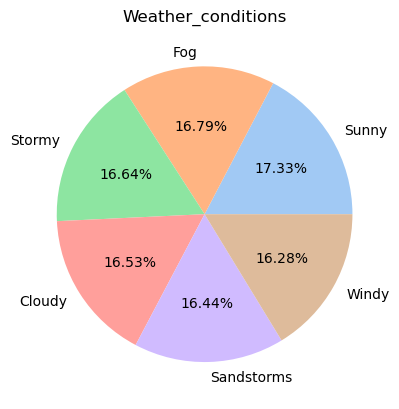

In [97]:
get_report(df, 'Weather_conditions')

Description:
count     45584
unique        4
top         Low
freq      16077
Name: Road_traffic_density, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
        Count  Frequency %
Low     16077    35.268954
Jam     14139    31.017462
Medium  10945    24.010618
High     4423     9.702966
**************************************************


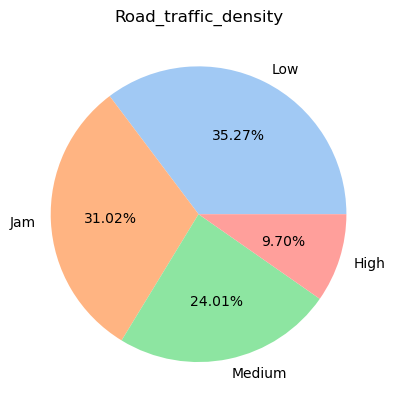

In [98]:
get_report(df, 'Road_traffic_density')

Description:
count    45584.000000
mean         1.023385
std          0.839055
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          3.000000
Name: Vehicle_condition, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
   Count  Frequency %
2  15031    32.974289
1  15028    32.967708
0  15005    32.917252
3    520     1.140751
**************************************************


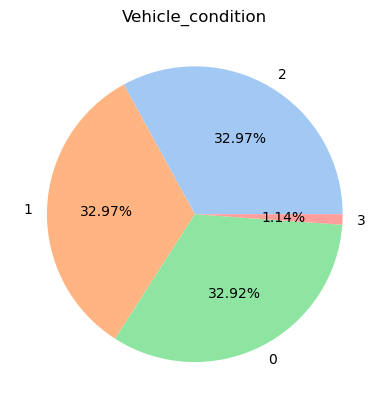

In [99]:
get_report(df, 'Vehicle_condition')

Description:
count     45584
unique        4
top       Snack
freq      11530
Name: Type_of_order, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
        Count  Frequency %
Snack   11530    25.293963
Meal    11456    25.131625
Drinks  11321    24.835469
Buffet  11277    24.738943
**************************************************


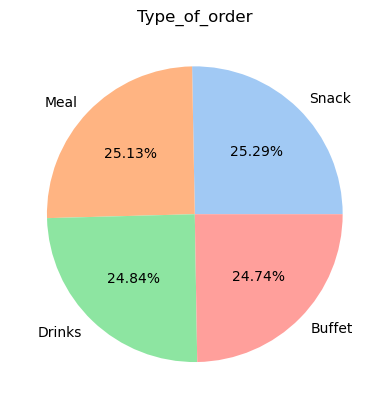

In [100]:
get_report(df, 'Type_of_order')

Description:
count          45584
unique             4
top       motorcycle
freq           26429
Name: Type_of_vehicle, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                  Count  Frequency %
motorcycle        26429    57.978677
scooter           15273    33.505177
electric_scooter   3814     8.366971
bicycle              68     0.149175
**************************************************


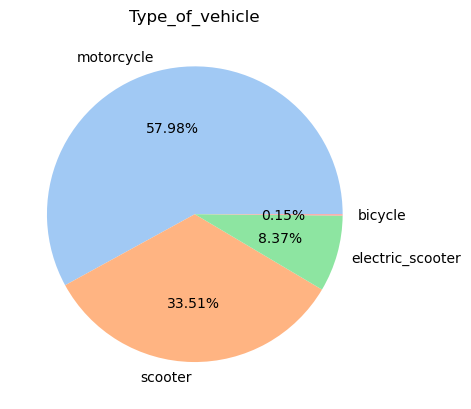

In [101]:
get_report(df, 'Type_of_vehicle')

Description:
count    45584.000000
mean         0.793765
std          0.654999
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          3.000000
Name: multiple_deliveries, dtype: float64
**************************************************
Object type:
float64
**************************************************
Value count:
     Count  Frequency %
1.0  28151    61.756318
0.0  14094    30.918743
2.0   1985     4.354598
3.0   1354     2.970340
**************************************************


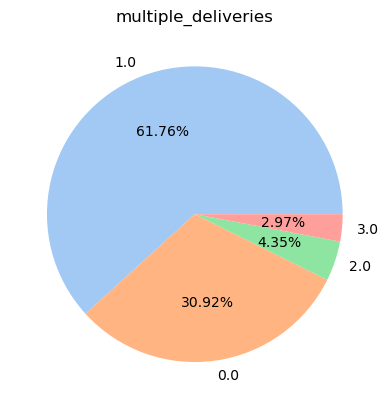

In [102]:
get_report(df, 'multiple_deliveries')

Description:
count     45584
unique        2
top          No
freq      44688
Name: Festival, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
     Count  Frequency %
No   44688    98.034398
Yes    896     1.965602
**************************************************


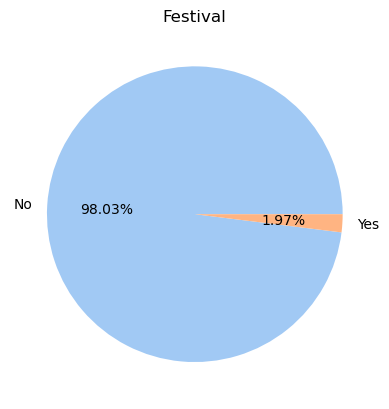

In [103]:
get_report(df, 'Festival')

Description:
count             45584
unique                3
top       Metropolitian
freq              34087
Name: City, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
               Count  Frequency %
Metropolitian  34087    74.778431
Urban          10133    22.229291
Semi-Urban      1364     2.992278
**************************************************


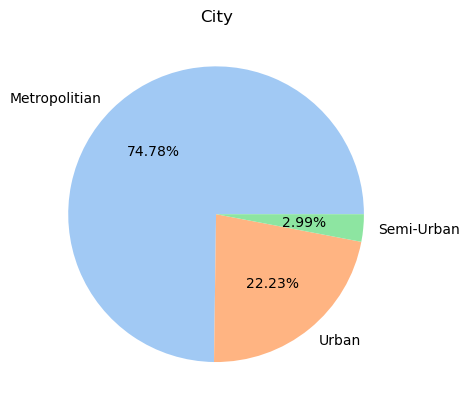

In [104]:
get_report(df, 'City')

Description:
count    45584.000000
mean        29.566911
std          5.695578
min         15.000000
25%         25.000000
50%         29.566911
75%         34.000000
max         50.000000
Name: Delivery_person_Age, dtype: float64
**************************************************
Object type:float64
**************************************************


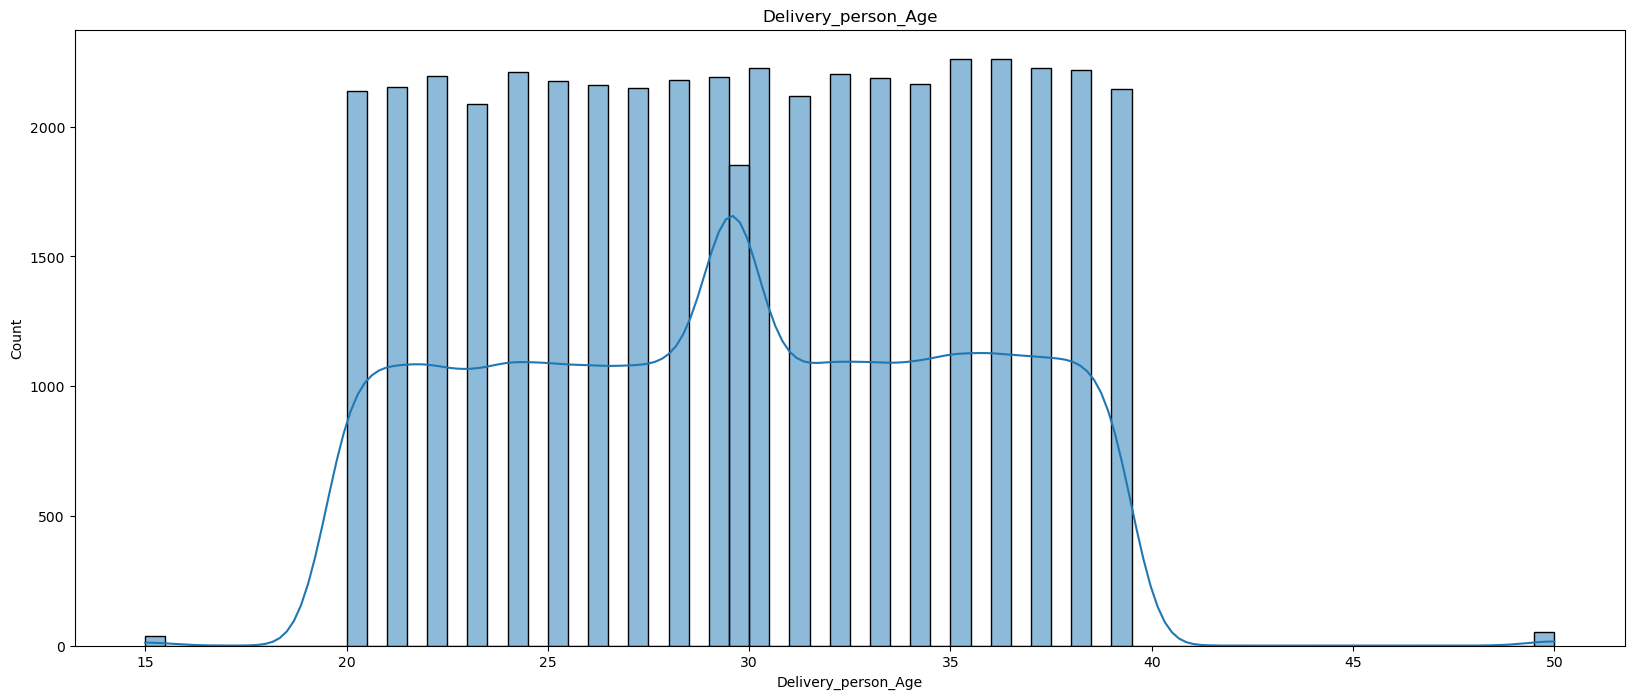

In [105]:
get_report(df, 'Delivery_person_Age')

Description:
count    45584.000000
mean         4.633774
std          0.327663
min          1.000000
25%          4.600000
50%          4.700000
75%          4.800000
max          6.000000
Name: Delivery_person_Ratings, dtype: float64
**************************************************
Object type:float64
**************************************************


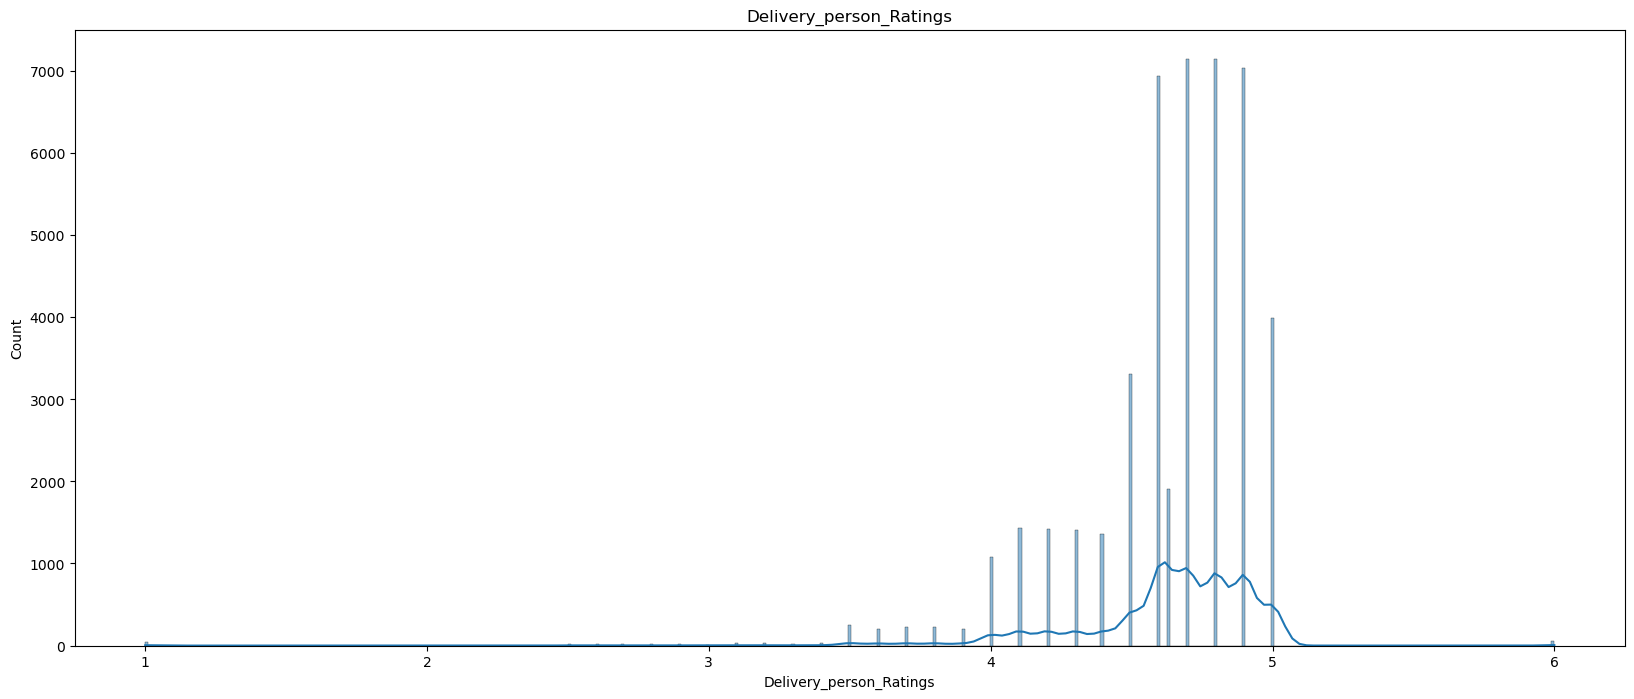

In [106]:
get_report(df, 'Delivery_person_Ratings')

In [37]:
def drop_features(df, feature):
    df = df.drop([feature], axis=1, inplace=True)
    return df

In [38]:
drop_features(df, 'ID')
drop_features(df, 'Delivery_person_ID')
drop_features(df, 'Restaurant_latitude')
drop_features(df, 'Restaurant_longitude')
drop_features(df, 'Delivery_location_latitude')
drop_features(df, 'Delivery_location_longitude')
drop_features(df, 'Order_Date')
drop_features(df, 'Time_Orderd')
drop_features(df, 'Time_Order_picked')

In [39]:
df

,Delivery_person_Age,Delivery_person_Ratings,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken (min),Displacement
0,36.0,4.2,Fog,Jam,2,Snack,motorcycle,3.0,No,Metropolitian,46,10.280596
1,21.0,4.7,Stormy,High,1,Meal,motorcycle,1.0,No,Metropolitian,23,6.242327
2,23.0,4.7,Sandstorms,Medium,1,Drinks,scooter,1.0,No,Metropolitian,21,13.787879
3,34.0,4.3,Sandstorms,Low,0,Buffet,motorcycle,0.0,No,Metropolitian,20,2.930262
4,24.0,4.7,Fog,Jam,1,Snack,scooter,1.0,No,Metropolitian,41,19.396645
...,...,...,...,...,...,...,...,...,...,...,...,...
45579,30.0,4.8,Windy,High,1,Meal,motorcycle,0.0,No,Metropolitian,32,1.489848
45580,21.0,4.6,Windy,Jam,0,Buffet,motorcycle,1.0,No,Metropolitian,36,11.007750
45581,30.0,4.9,Cloudy,Low,1,Drinks,scooter,0.0,No,Metropolitian,16,4.657202
45582,20.0,4.7,Cloudy,High,0,Snack,motorcycle,1.0,No,Metropolitian,26,6.232402


In [48]:
df['City'].unique()

array(['Metropolitian', 'Urban', 'Semi-Urban'], dtype=object)

C:\Users\rushi\AppData\Local\Temp\ipykernel_28556\3882197229.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.zeros_like(df.corr('spearman'))
C:\Users\rushi\AppData\Local\Temp\ipykernel_28556\3882197229.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr('spearman'), annot=True, cmap='flare', linewidths=.5, mask=mask)


<AxesSubplot: >

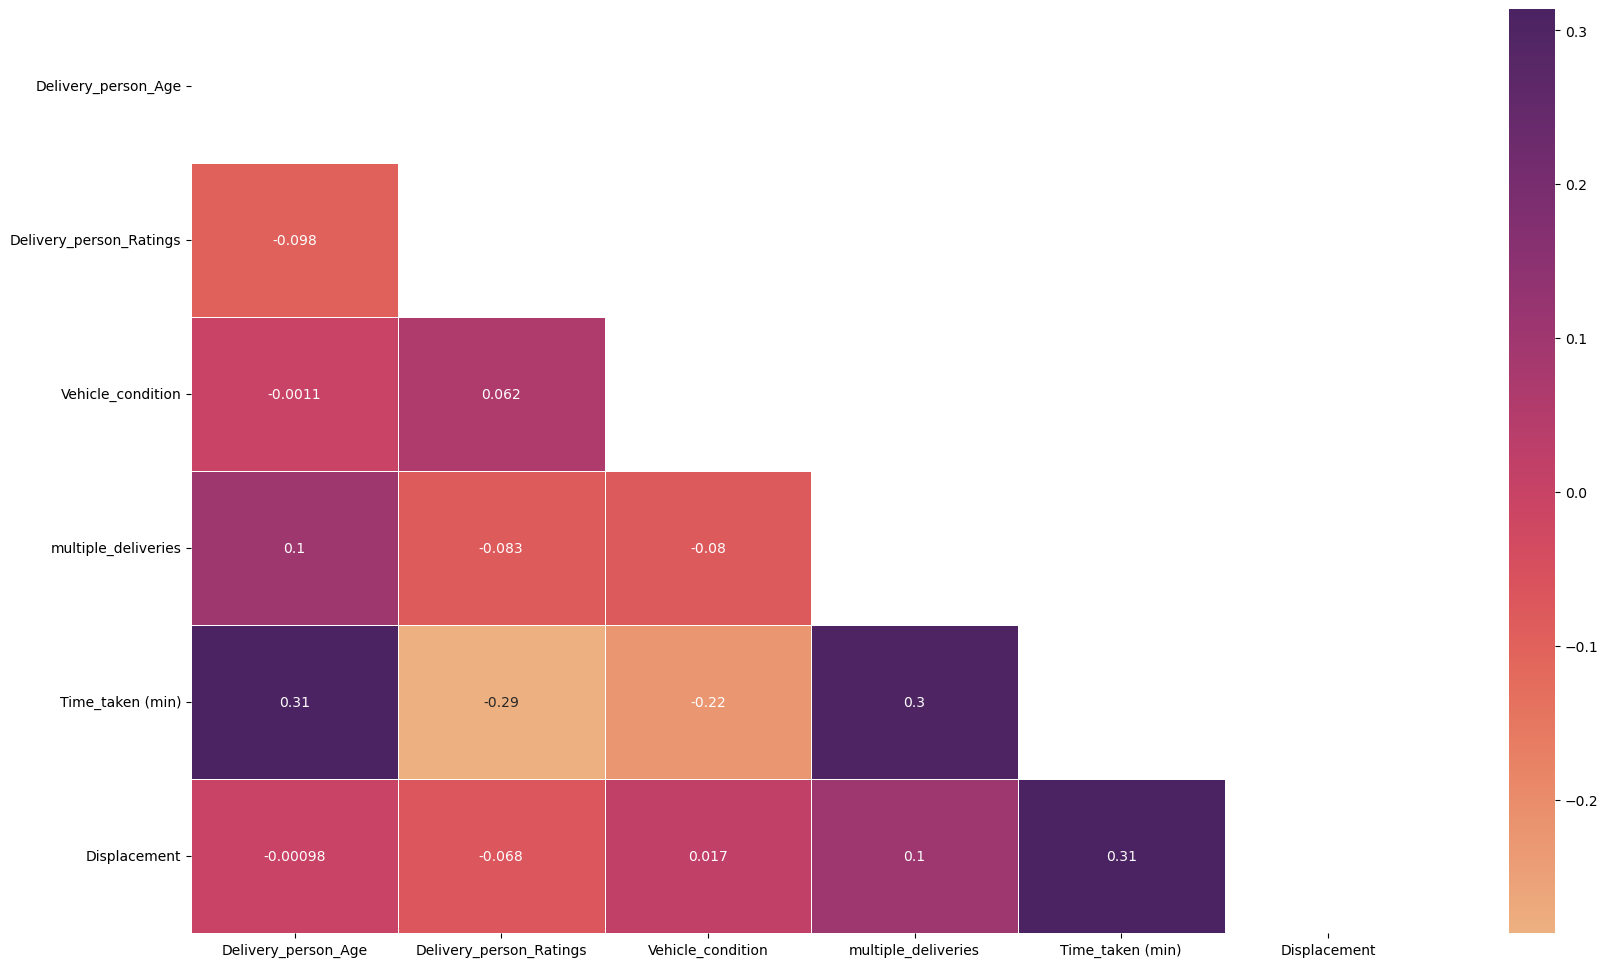

In [110]:
figure(figsize=(20, 12))
mask = np.zeros_like(df.corr('spearman'))
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.corr('spearman'), annot=True, cmap='flare', linewidths=.5, mask=mask)

In [111]:
df.head()

,Delivery_person_Age,Delivery_person_Ratings,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken (min),Displacement
0,36.0,4.2,Fog,Jam,2,Snack,motorcycle,3.0,No,Metropolitian,46,10.280596
1,21.0,4.7,Stormy,High,1,Meal,motorcycle,1.0,No,Metropolitian,23,6.242327
2,23.0,4.7,Sandstorms,Medium,1,Drinks,scooter,1.0,No,Metropolitian,21,13.787879
3,34.0,4.3,Sandstorms,Low,0,Buffet,motorcycle,0.0,No,Metropolitian,20,2.930262
4,24.0,4.7,Fog,Jam,1,Snack,scooter,1.0,No,Metropolitian,41,19.396645


In [112]:
class encoding(BaseEstimator, TransformerMixin):
    def __init__(self, columns=['Weather_conditions', 'Road_traffic_density', 'Type_of_order', 'Type_of_vehicle', 'Festival', 'City']):
        self.columns = columns
    def fit(self, df):
        return self
    def transform(self, df):
        oe = OrdinalEncoder()
        df[self.columns] = oe.fit_transform(df[self.columns])
        return df

In [113]:
class feature_scaling(BaseEstimator, TransformerMixin):
    def __init__(self, columns=['Delivery_person_Age', 'Delivery_person_Ratings', 'Displacement']):
        self.columns = columns
    def fit(self, df):
        return self
    def transform(self, df):
        sc = StandardScaler()
        df[self.columns] = sc.fit_transform(df[self.columns])
        return df

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45584 entries, 0 to 45583
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Delivery_person_Age      45584 non-null  float64
 1   Delivery_person_Ratings  45584 non-null  float64
 2   Weather_conditions       45584 non-null  object 
 3   Road_traffic_density     45584 non-null  object 
 4   Vehicle_condition        45584 non-null  int64  
 5   Type_of_order            45584 non-null  object 
 6   Type_of_vehicle          45584 non-null  object 
 7   multiple_deliveries      45584 non-null  float64
 8   Festival                 45584 non-null  object 
 9   City                     45584 non-null  object 
 10  Time_taken (min)         45584 non-null  int64  
 11  Displacement             45584 non-null  float64
dtypes: float64(4), int64(2), object(6)
memory usage: 4.2+ MB


class data_conv(BaseEstimator, TransformerMixin):
    def __

In [115]:
pipe = Pipeline([
    ('encoding', encoding()),
    ('feature_scaling', feature_scaling())
])

In [116]:
pipe

Pipeline(steps=[('encoding', encoding()),
                ('feature_scaling', feature_scaling())])

In [117]:
pipe.fit_transform(df)

,Delivery_person_Age,Delivery_person_Ratings,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken (min),Displacement
0,1.129501,-1.323855,1.0,1.0,2,3.0,2.0,3.0,0.0,0.0,46,-0.080959
1,-1.504150,0.202119,3.0,0.0,1,2.0,2.0,1.0,0.0,0.0,23,-0.084631
2,-1.152997,0.202119,2.0,3.0,1,1.0,3.0,1.0,0.0,0.0,21,-0.077770
3,0.778347,-1.018660,2.0,2.0,0,0.0,2.0,0.0,0.0,0.0,20,-0.087642
4,-0.977420,0.202119,1.0,1.0,1,3.0,3.0,1.0,0.0,0.0,41,-0.072670
...,...,...,...,...,...,...,...,...,...,...,...,...
45579,0.076040,0.507314,5.0,0.0,1,2.0,2.0,0.0,0.0,0.0,32,-0.088952
45580,-1.504150,-0.103076,5.0,1.0,0,0.0,2.0,1.0,0.0,0.0,36,-0.080298
45581,0.076040,0.812509,0.0,2.0,1,1.0,3.0,0.0,0.0,0.0,16,-0.086072
45582,-1.679727,0.202119,0.0,0.0,0,3.0,2.0,1.0,0.0,0.0,26,-0.084640


In [139]:
df['Vehicle_condition'] = df['Vehicle_condition'].astype(float)

In [140]:
df.columns

Index(['Delivery_person_Age', 'Delivery_person_Ratings', 'Weather_conditions',
       'Road_traffic_density', 'Vehicle_condition', 'Type_of_order',
       'Type_of_vehicle', 'multiple_deliveries', 'Festival', 'City',
       'Time_taken (min)', 'Displacement'],
      dtype='object')

In [49]:
x = df.drop(['Time_taken (min)'], axis=1)
y = df['Time_taken (min)']

In [50]:
x

,Delivery_person_Age,Delivery_person_Ratings,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Displacement
0,36.0,4.2,Fog,Jam,2,Snack,motorcycle,3.0,No,Metropolitian,10.280596
1,21.0,4.7,Stormy,High,1,Meal,motorcycle,1.0,No,Metropolitian,6.242327
2,23.0,4.7,Sandstorms,Medium,1,Drinks,scooter,1.0,No,Metropolitian,13.787879
3,34.0,4.3,Sandstorms,Low,0,Buffet,motorcycle,0.0,No,Metropolitian,2.930262
4,24.0,4.7,Fog,Jam,1,Snack,scooter,1.0,No,Metropolitian,19.396645
...,...,...,...,...,...,...,...,...,...,...,...
45579,30.0,4.8,Windy,High,1,Meal,motorcycle,0.0,No,Metropolitian,1.489848
45580,21.0,4.6,Windy,Jam,0,Buffet,motorcycle,1.0,No,Metropolitian,11.007750
45581,30.0,4.9,Cloudy,Low,1,Drinks,scooter,0.0,No,Metropolitian,4.657202
45582,20.0,4.7,Cloudy,High,0,Snack,motorcycle,1.0,No,Metropolitian,6.232402


<AxesSubplot: >

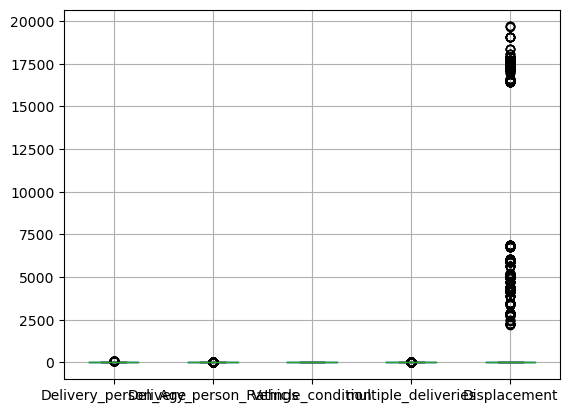

In [51]:
x.boxplot()

In [142]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [150]:
models = {
    "LinearRegression": LinearRegression(n_jobs=-1),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "RandomForest": RandomForestRegressor()
}

In [159]:
def train_model(model, model_name, x_train= x_train, x_test = x_test, y_train = y_train, y_test = y_test):
    print("#"*50)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(model_name,":")
    print("r2_score", r2_score(y_test, y_pred))
    print("Score", ":", mean_squared_error(y_pred, y_test))
    print("Mean score", ":", np.sqrt(mean_squared_error(y_pred, y_test)))

In [160]:
for model_name, model in models.items():
    train_model(model, model_name)

##################################################
LinearRegression :
r2_score 0.4102740697049606
Score : 52.68117717241385
Mean score : 7.25818001791178
##################################################
Ridge :
r2_score 0.41027238712527325
Score : 52.68132747999582
Mean score : 7.258190372261933
##################################################
Lasso :
r2_score 0.2833590062987619
Score : 64.0187063494081
Mean score : 8.001169061418969
##################################################
ElasticNet :
r2_score 0.2784245941438813
Score : 64.45950541829578
Mean score : 8.028667723744443
##################################################
RandomForest :
r2_score 0.8135520011841184
Score : 16.655703191052453
Mean score : 4.081139937695405
